<a href="https://colab.research.google.com/github/megsdata/deriveBP_fromPPG/blob/main/BPfromPPG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install packages

In [ ]:
!pip install kaggle
!pip install numpy scipy scikit-learn pandas joblib
!pip install deap update_checker tqdm stopit
!pip install tpot

     |████████████████████████████████| 163kB 7.0MB/s 
  Created wheel for stopit: filename=stopit-1.1.2-cp36-none-any.whl size=11956 sha256=1d2ea1a06e940a948da00d0f63ab4dc7ab4124ff193803ea18dc5f0214488d38
  Stored in directory: /root/.cache/pip/wheels/3c/85/2b/2580190404636bfc63e8de3dff629c03bb795021e1983a6cc7
Successfully built stopit
     |████████████████████████████████| 92kB 4.0MB/s 


Download dataset from kaggle

In [ ]:
from google.colab import files
files.upload() # upload kaggle.json here
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d mkachuee/BloodPressureDataset

import zipfile
zip_ref = zipfile.ZipFile('BloodPressureDataset.zip', 'r')
zip_ref.extractall('BloodPressureDataset')
zip_ref.close()

Saving kaggle.json to kaggle.json
100% 4.59G/4.60G [01:02<00:00, 53.2MB/s]
100% 4.60G/4.60G [01:02<00:00, 78.4MB/s]


# Data Processing

Import packages, adjust settings

In [ ]:
# Data manipulation
import numpy as np 
import pandas as pd
import scipy.io
from sklearn.model_selection import KFold, train_test_split

import scipy.signal as ss

import math
import statistics

import numpy.polynomial.polynomial as poly
import numpy.polynomial.polyutils

# Network
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import preprocessing
from tpot import TPOTRegressor
from sklearn.svm import SVR

# Visualisation
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tnrange, tqdm_notebook

In [ ]:
sns.set_style("darkgrid")

Read data

In [ ]:
def load_data(sample_number):
  # Loading a sample .mat file to understand the data dimensions
  print(f'Loading data from part_{sample_number}.mat...')
  test_sample = scipy.io.loadmat(f'BloodPressureDataset/part_{sample_number}.mat')['p']
  print(f'Sample data type: {type(test_sample)}')
  print(f'Sample shape: {test_sample.shape}')
  print(f"Total Samples: {len(test_sample[0])}")
  print(f"Number of readings in each sample (column): {len(test_sample[0][0])}")
  print(f"Number of samples in each reading (ECG): {len(test_sample[0][0][2])}")
  # Extract signals
  print('Extracting PPG, BP and ECG data...')
  temp_mat = test_sample[0, test_sample.shape[1]-1]
  temp_length = temp_mat.shape[1]
  sample_size = 125 # config['sample_size']
  ppg = []
  bp = []
  ecg = []

  for i in range(len(test_sample[0])):
      temp_mat = test_sample[0, i]
      temp_length = temp_mat.shape[1]
      for j in range((int)(temp_length/sample_size)):
          temp_ppg = temp_mat[0, j*sample_size:(j+1)*sample_size]
          temp_ecg = temp_mat[2, j*sample_size:(j+1)*sample_size]
          temp_bp = temp_mat[1, j*sample_size:(j+1)*sample_size]
          ppg.append(temp_ppg)
          ecg.append(temp_ecg)
          bp.append(temp_bp)
  ppg, ecg, bp = np.array(ppg).reshape(-1,1), np.array(ecg).reshape(-1,1), np.array(bp).reshape(-1,1)
  print(f'PPG shape: {ppg.shape}\nECG shape: {ecg.shape}\nBP shape: {bp.shape}')
  t = (np.arange(len(ppg))/125).reshape(-1,1)
  return pd.DataFrame(np.hstack((t, ppg, ecg, bp))).rename(columns={0: 'time', 1: 'ppg', 2: 'ecg', 3: 'bp'})

In [ ]:
part_1 = load_data(1)
part_1.describe()

Loading data from part_1.mat...
Sample data type: <class 'numpy.ndarray'>
Sample shape: (1, 1000)
Total Samples: 1000
Number of readings in each sample (column): 3
Number of samples in each reading (ECG): 61000
Extracting PPG, BP and ECG data...
PPG shape: (32061000, 1)
ECG shape: (32061000, 1)
BP shape: (32061000, 1)


,time,ppg,ecg,bp
count,3.206100e+07,3.206100e+07,3.206100e+07,3.206100e+07
mean,1.282440e+05,1.687430e+00,1.328386e-01,9.141352e+01
std,7.404171e+04,6.868613e-01,5.900131e-01,2.832491e+01
min,0.000000e+00,0.000000e+00,-3.498047e+00,5.001624e+01
25%,6.412200e+04,1.154448e+00,-1.413043e-01,6.935863e+01
50%,1.282440e+05,1.504399e+00,2.651367e-01,8.328889e+01
75%,1.923660e+05,2.225806e+00,5.048876e-01,1.078477e+02
max,2.564880e+05,4.001955e+00,4.500000e+00,1.999093e+02


Text(0.5, 0, 'Time, s')

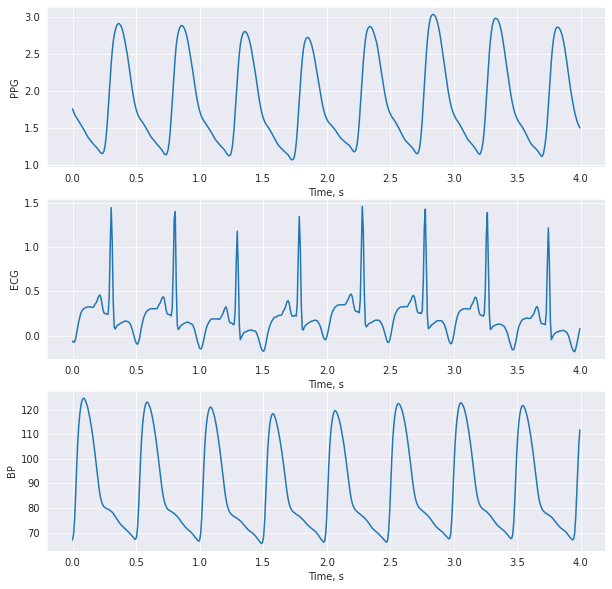

In [ ]:
time = 4
# 125 is sampling rate
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(10,10))
sns.lineplot(data=part_1.head(125*time), x='time', y='ppg', ax=ax1)
sns.lineplot(data=part_1.head(125*time), x='time', y='ecg', ax=ax2)
sns.lineplot(data=part_1.head(125*time), x='time', y='bp', ax=ax3)
ax1.set_ylabel('PPG')
ax1.set_xlabel('Time, s')
ax2.set_ylabel('ECG')
ax2.set_xlabel('Time, s')
ax3.set_ylabel('BP')
ax3.set_xlabel('Time, s')
plt.xlabel('Time, s')

In [ ]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = ss.butter(order, [low, high], btype='band')
    return b, a

(b, a) = butter_bandpass(0.5, 8, 125)
ppg_filt = ss.filtfilt(b, a, part_1['ppg']) # apply fwd-bwd to reduce group delay
bp_filt = ss.filtfilt(b,a, part_1['bp'])

b, a = signal.iirnotch(f0, Q, fs)
ppg_filt = ss.filtfilt(b, a, ppg_filt)
bp_filt = ss.filtfilt(b,a, bp_filt)

Example PPG peak detection

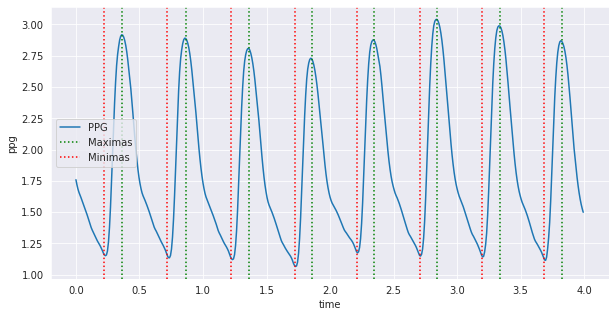

In [ ]:
pks, _ = ss.find_peaks(ppg_filt) # sysloci peaks
vlys, _ = ss.find_peaks(-ppg_filt) # foot valleys

fig, (ax1) = plt.subplots(1,1, figsize=(10,5))
sns.lineplot(data=part_1.head(125*4), x='time', y='ppg', ax=ax1, label='PPG')

plt.axvline(pks[0]/125, color='g', ls=':', label='Maximas') # label
for i in range(1,10):
  if pks[i]/125 > 4: break
  plt.axvline(pks[i]/125, color='g', ls=':')

plt.axvline(vlys[0]/125, color='r', ls=':', label='Minimas') # label
for i in range(1,10):
  if vlys[i]/125 > 4: break
  plt.axvline(vlys[i]/125, color='r', ls=':')

plt.legend()

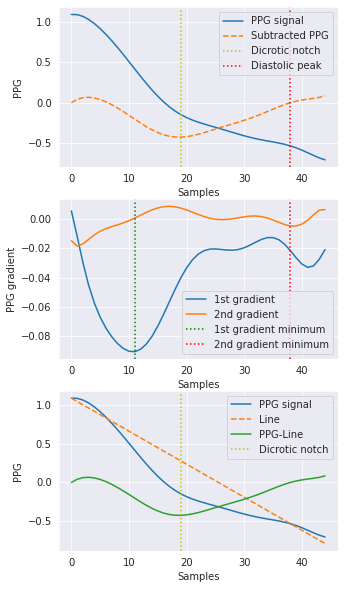

In [ ]:
# take sample from low to low (red to red)
i = 0 # PPG/BP period index (min to min - red to red)
# divide interval into ascending and descending parts
ascending = None
descending  = None
if vlys[i] < pks[i] and pks[i] < vlys[i+1]: # normal case
  ascending = range(vlys[i], pks[i])
  descending = range(pks[i], vlys[i+1])
else:
  idx = np.where(np.logical_and(vlys[i] < pks, pks < vlys[i+1])) # search for peak
  # todo trow error if idx not found
  ascending = range(vlys[i], pks[idx]);
  descending = range(pks[idx], vlys[i+1])

# normalization - not actually used
tmp_desc =  np.take(ppg_filt,descending)
# scaler = preprocessing.MinMaxScaler()
# tmp_desc = scaler.fit_transform(np.take(ppg_filt,descending).reshape(-1,1)).squeeze() # scaled descending part
tmp_idx = np.arange(0, len(tmp_desc)) # sample index vector

# fit polynomials
poly_ppg = poly.polyfit(tmp_idx, tmp_desc, 12)
poly_grad1 = poly.polyder(poly_ppg)
poly_grad2 = poly.polyder(poly_grad1)
val_grad1 = poly.polyval(tmp_idx, poly_grad1)
val_grad2 = poly.polyval(tmp_idx, poly_grad2)
grad1_vlys, _ = ss.find_peaks(-val_grad1) # valleys of 1st derivative
grad1_min = grad1_vlys[0] # take 1st valley of 1st derivative
grad2_vlys, _ = ss.find_peaks(-val_grad2[grad1_min:]) # we know valley is located after 1st derivative's 1st minimum
grad2_min = grad2_vlys[-1] + grad1_min # diastolic peak position (last one)

# find dichrotic notch
line = poly.polyfit([0, grad2_min], [tmp_desc[0], tmp_desc[grad2_min]], 1)
val_line = poly.polyval(tmp_idx, line)
diff = tmp_desc - val_line
diff_vlys, _ = ss.find_peaks(-diff)
notch_index = diff_vlys[0]


# plots
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(5,10))

ax1.plot(tmp_desc, label='PPG signal')
ax1.plot(diff, label='Subtracted PPG', ls='--')
ax1.axvline(notch_index, ls=':', label='Dicrotic notch', c='y')
ax1.axvline(grad2_min, ls=':', label='Diastolic peak', c='r')
ax1.legend()
ax1.set_xlabel('Samples')
ax1.set_ylabel('PPG')

ax2.plot(val_grad1, label='1st gradient')
ax2.plot(val_grad2, label='2nd gradient')
ax2.axvline(grad1_min, ls=':', label='1st gradient minimum', c='g')
ax2.axvline(grad2_min, ls=':', label='2nd gradient minimum', c='r')
ax2.legend()
ax2.set_xlabel('Samples')
ax2.set_ylabel('PPG gradient')

ax3.plot(tmp_desc, label='PPG signal')
ax3.plot(val_line, label='Line', ls='--')
ax3.plot(diff, label='PPG-Line')
ax3.axvline(notch_index, ls=':', label='Dicrotic notch', c='y')
ax3.set_xlabel('Samples')
ax3.set_ylabel('PPG')
ax3.legend()

Actual code for processing data

In [ ]:
# divide interval into ascending and descending parts
def split(pks, vlys, idx):
  ascending = None
  descending  = None
  if vlys[idx] < pks[idx] and pks[idx] < vlys[idx+1]: # normal case
    ascending = range(vlys[idx], pks[idx])
    descending = range(pks[idx], vlys[idx+1])
  else:
    pos = np.where(np.logical_and(vlys[idx] < pks, pks < vlys[idx+1]))[0][0] # search for peak
    # todo trow error if idx not found
    ascending = range(vlys[idx], pks[pos]);
    descending = range(pks[pos], vlys[idx+1])
  return ascending, descending


def diastolic_idx(signal, points):
  poly_ppg = poly.polyfit(points, signal, 12)
  poly_grad1 = poly.polyder(poly_ppg)
  poly_grad2 = poly.polyder(poly_grad1)
  val_grad1 = poly.polyval(points, poly_grad1)
  val_grad2 = poly.polyval(points, poly_grad2)
  grad1_vlys, _ = ss.find_peaks(-val_grad1)
  if(len(grad1_vlys)<1): return points[len(points)//4*3]
  grad1_min = grad1_vlys[0]
  grad2_vlys, _ = ss.find_peaks(-val_grad2[grad1_min:])
  if(len(grad2_vlys)<1): return points[len(points)//4*3]
  return grad2_vlys[-1] + grad1_min # diastolic minimum position



def dicrotic_notch(signal, points, sys_idx):
  line = poly.polyfit([0, sys_idx], [signal[0], signal[sys_idx]], 1)
  val_line = poly.polyval(points, line)
  diff = signal - val_line
  diff_vlys, _ = ss.find_peaks(-diff)
  if(len(diff_vlys)<1): return points[len(points)//5*3]
  return diff_vlys[0]


def get_batch(data, sz):
  idx = 0
  while idx + sz < len(data):
    yield data[idx:idx+sz]
    idx = idx + sz

# do time batching to extract features of both ppg and bp.
sample_len = 125*4 # 4 seconds sample size
input_len = len(ppg_filt)
ppg_generator = get_batch(ppg_filt, sample_len)
bp_generator = get_batch(bp_filt, sample_len)

features = pd.DataFrame()

ppg_diast_pressure = []
ppg_syst_pressure = []
ppg_foot_pressure = []
ppg_notch_pressure = []

bp_diast_pressure = []
bp_syst_pressure = []
bp_foot_pressure = []
bp_notch_pressure = []

for i in tnrange(input_len//sample_len-1):
  # process ppg signal
  try:
    interval = np.array(next(ppg_generator))
  except StopIteration as e:
        print(e)
        break
  pks, _ = ss.find_peaks(interval)
  vlys, _ = ss.find_peaks(-interval)
  ppg_diast_vals = []
  ppg_syst_vals = []
  ppg_foot_vals = []
  ppg_notch_vals = []
  for j in range(0, len(vlys)-1):
    _, desc_idx = split(pks, vlys, j)
    descending = interval[desc_idx]
    t_idx = np.arange(0, len(descending)) # index vector, need for evaluating
    diast_idx = diastolic_idx(descending, t_idx)
    notch_idx = dicrotic_notch(descending, t_idx, diast_idx)
    ppg_syst_vals.append(descending[0]) # systolic peak pressure
    ppg_diast_vals.append(descending[diast_idx]) # diastolic peak pressure
    ppg_foot_vals.append(descending[-1]) # foot pressure
    ppg_notch_vals.append(descending[notch_idx])
  # calculate mean
  ppg_diast_pressure.append(np.mean(ppg_diast_vals))
  ppg_syst_pressure.append(np.mean(ppg_syst_vals))
  ppg_foot_pressure.append(np.mean(ppg_foot_vals))
  ppg_notch_pressure.append(np.mean(ppg_notch_vals))
  # process bp signal
  try:
    interval = np.array(next(bp_generator))
  except StopIteration as e:
    print(e)
    break
  pks, _ = ss.find_peaks(interval)
  vlys, _ = ss.find_peaks(-interval)
  bp_syst_vals = []
  bp_foot_vals = []
  bp_notch_vals = []
  for j in range(0, len(vlys)-1):
    _, desc_idx = split(pks, vlys, j)
    descending = interval[desc_idx]
    t_idx = np.arange(0, len(descending)) # index vector, need for evaluating
    diast_idx = diastolic_idx(descending, t_idx)
    notch_idx = dicrotic_notch(descending, t_idx, diast_idx)
    bp_syst_vals.append(descending[0])
    bp_foot_vals.append(descending[-1]) # dont need to add offset - last value
    bp_notch_vals.append(descending[notch_idx])
  bp_syst_pressure.append(np.mean(bp_syst_vals))
  # bp does not have diastolic peaks
  bp_foot_pressure.append(np.mean(bp_foot_vals)) # actually our diastolic pressure
  bp_notch_pressure.append(np.mean(bp_notch_vals))

features['PPG Systolic Pressure'] = ppg_syst_pressure
features['PPG Diastolic Pressure'] = ppg_diast_pressure
features['PPG Foot Pressure'] = ppg_foot_pressure
features['PPG Notch Pressure'] = ppg_notch_pressure
features['BP Systolic Pressure'] = bp_syst_pressure
features['BP Diastolic Pressure'] = bp_foot_pressure # diastolic pressure is foot pressure for bp
features['BP Notch Pressure'] = bp_notch_pressure

features.to_csv('features.csv')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


/usr/local/lib/python3.6/dist-packages/numpy/polynomial/polynomial.py:1336: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Look at the features...

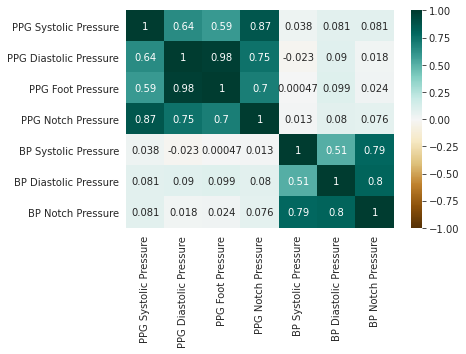

In [ ]:
sns.heatmap(features.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')

In [ ]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64121 entries, 0 to 64120
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   PPG Systolic Pressure   64121 non-null  float64
 1   PPG Diastolic Pressure  64121 non-null  float64
 2   PPG Foot Pressure       64121 non-null  float64
 3   PPG Notch Pressure      64121 non-null  float64
 4   BP Systolic Pressure    64115 non-null  float64
 5   BP Diastolic Pressure   64115 non-null  float64
 6   BP Notch Pressure       64115 non-null  float64
dtypes: float64(7)
memory usage: 3.4 MB


In [ ]:
features.describe()

,PPG Systolic Pressure,PPG Diastolic Pressure,PPG Foot Pressure,PPG Notch Pressure,BP Systolic Pressure,BP Diastolic Pressure,BP Notch Pressure
count,64121.000000,64121.000000,64121.000000,64121.000000,64115.000000,64115.000000,64115.000000
mean,2.241751,1.137596,1.087083,1.518052,119.948096,76.379230,92.048810
std,0.504900,0.225979,0.212501,0.339785,21.937135,16.032734,18.315878
min,0.401760,0.176651,0.151096,0.287390,59.763475,50.553648,56.005374
25%,1.975888,1.068589,1.036046,1.368449,104.757881,64.935731,77.749464
50%,2.208993,1.130661,1.080482,1.496858,116.793466,72.642037,87.968232
75%,2.606549,1.233138,1.167155,1.700880,133.437567,83.556405,105.195287
max,3.569892,2.311632,2.309677,2.804497,197.569324,190.863791,191.519644


Drop entries with missing values

In [ ]:
# Check null values
missing = features.isnull().any(axis=1)
features[missing]
# not many - just drop them
features = features.dropna()

Make a 40-60 train-validation split

In [ ]:
random_state = 42
valid_size = 0.4 # 40-60 valid-train split
selected_features = ['PPG Systolic Pressure', 'PPG Diastolic Pressure', 'PPG Foot Pressure',
       'PPG Notch Pressure']
train, valid = train_test_split(features, test_size=valid_size, random_state=random_state)

Train systolic estimator

In [ ]:
tpot_systolic = TPOTRegressor(generations=10,verbosity=2, random_state=random_state, population_size=20, cv=3, early_stop=4, warm_start=True)
tpot_systolic.fit(train[selected_features], train['BP Systolic Pressure'])
tpot_systolic.export('tpot_exported_pipeline_systolic.py')


Generation 1 - Current best internal CV score: -406.4605441076706

Generation 2 - Current best internal CV score: -404.7135742369193

Generation 3 - Current best internal CV score: -404.3439077755329

Generation 4 - Current best internal CV score: -401.8914175715839

Generation 5 - Current best internal CV score: -401.72030830340447

Generation 6 - Current best internal CV score: -401.72030830340447

Generation 7 - Current best internal CV score: -401.72030830340447

Generation 8 - Current best internal CV score: -401.72030830340447

Generation 9 - Current best internal CV score: -400.6071323025194

Generation 10 - Current best internal CV score: -400.6071323025194

Best pipeline: RandomForestRegressor(StandardScaler(CombineDFs(input_matrix, FastICA(input_matrix, tol=0.9))), bootstrap=True, max_features=0.45, min_samples_leaf=11, min_samples_split=9, n_estimators=100)


MSE of training  395.4929790527043
MAE of validation  15.523163947097096
MSE of validation  395.4929790527043


Text(0, 0.5, 'Number of samples')

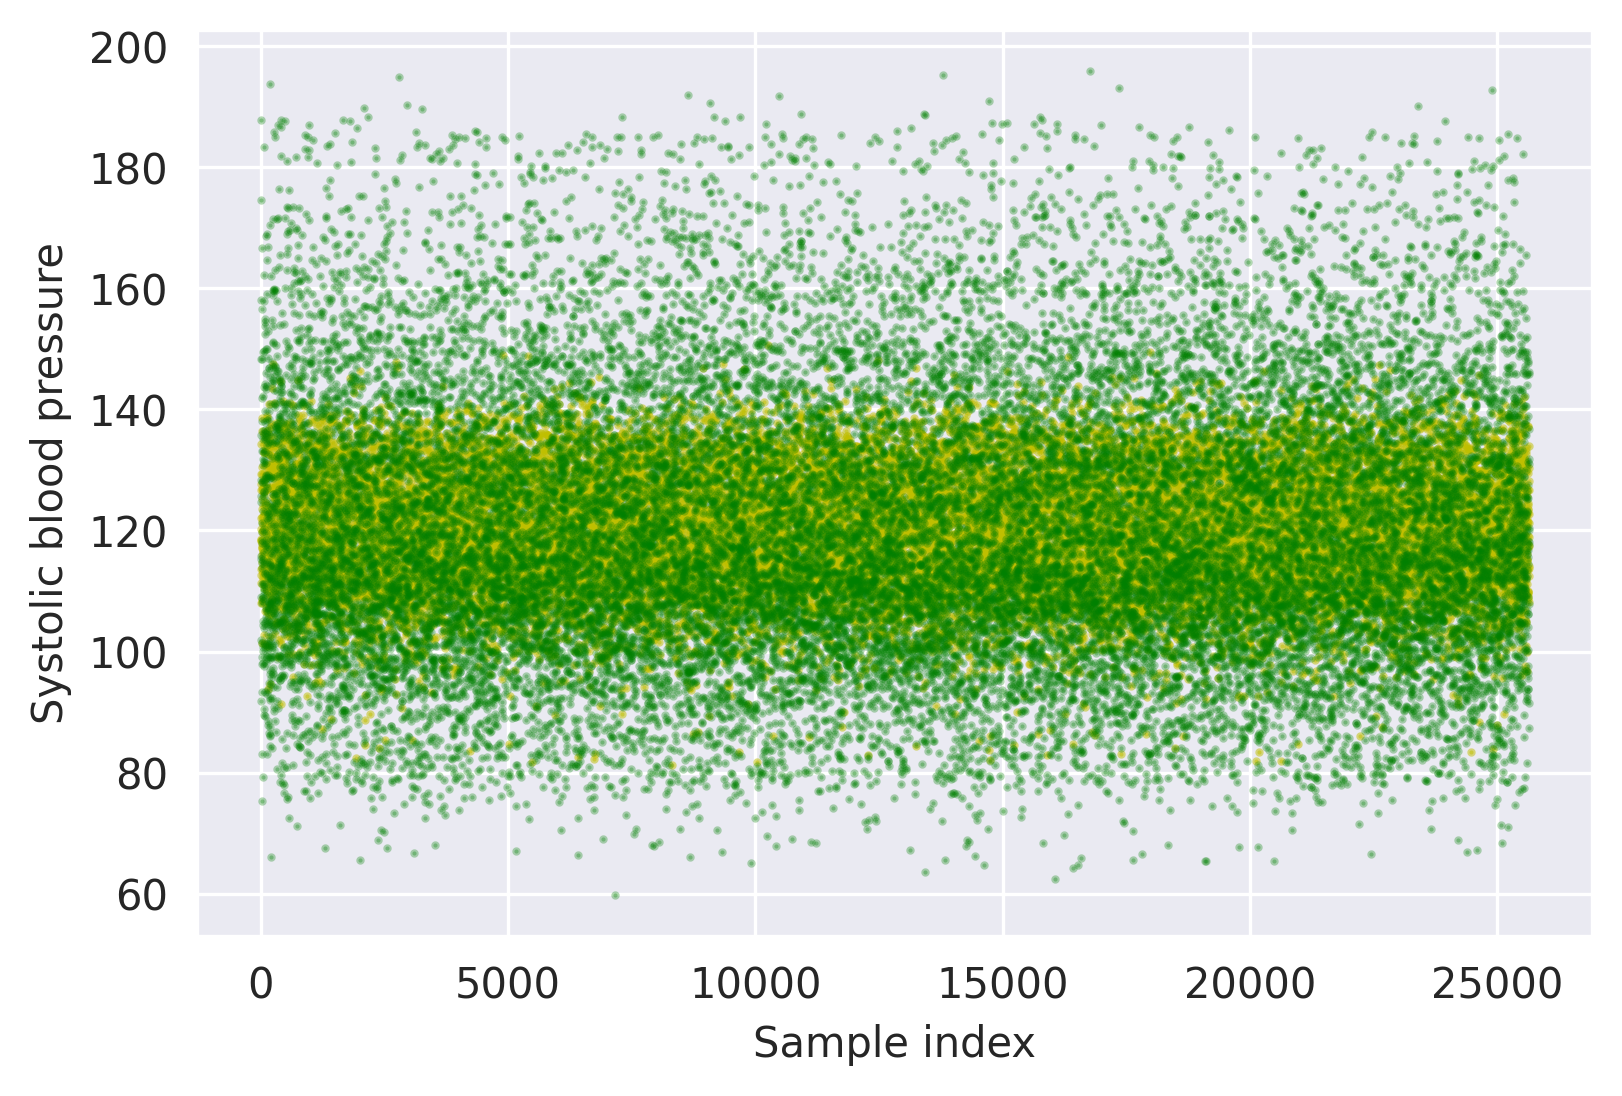

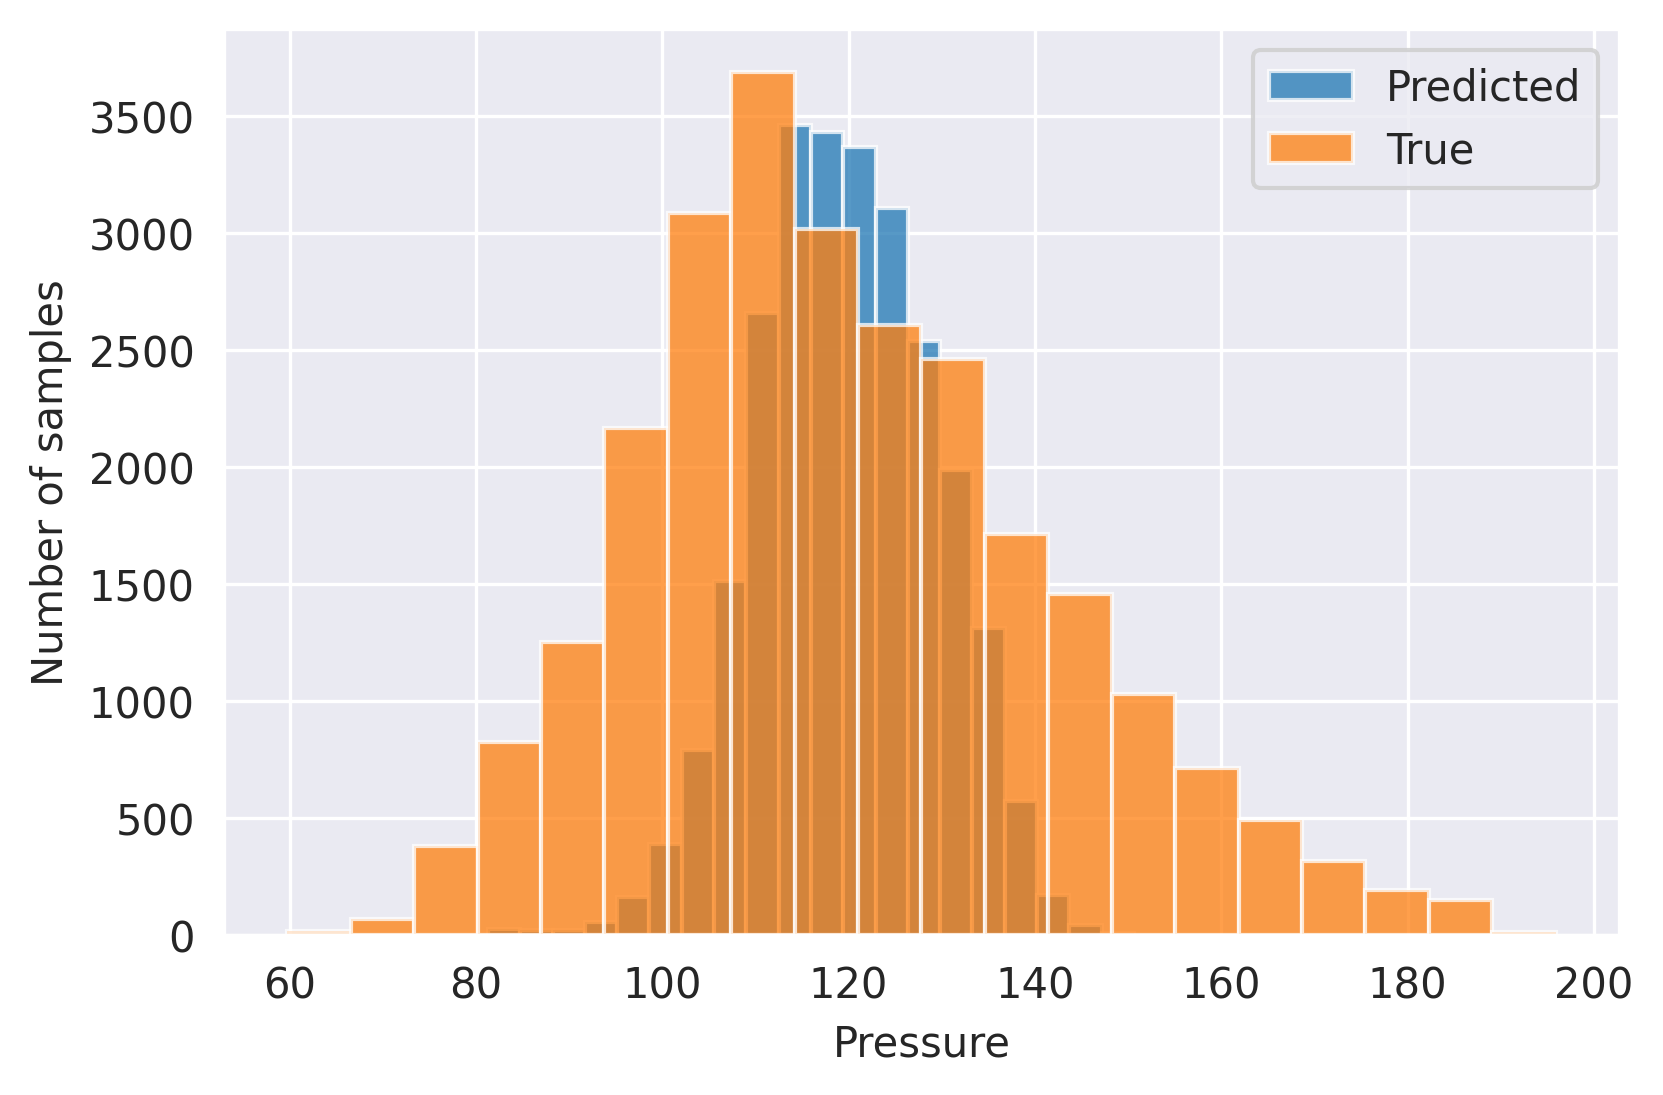

In [ ]:
print('MSE of training ', -tpot_systolic.score(valid[selected_features], valid['BP Systolic Pressure'])) # negative mean squeare error

pred = tpot_systolic.predict(valid[selected_features])
print('MAE of validation ', mean_absolute_error(y_true=valid['BP Systolic Pressure'], y_pred=pred))
print('MSE of validation ', mean_squared_error(y_true=valid['BP Systolic Pressure'], y_pred=pred))

dpi = 300
plt.figure(dpi=dpi)
x = range(0, len(pred))
plt.scatter(x,pred, c='y', s=1, label='Predicted', alpha=0.5)
plt.scatter(x, valid['BP Systolic Pressure'], c='g', s=1, label='True', alpha=0.3)
plt.xlabel('Sample index')
plt.ylabel('Systolic blood pressure')

plt.figure(dpi=dpi)
plt.hist(pred, alpha=0.75, label='Predicted', bins=20)
plt.hist(valid['BP Systolic Pressure'], alpha=0.75, label='True', bins=20)
plt.legend()
plt.xlabel('Pressure')
plt.ylabel('Number of samples')

Train diastolic estimator

In [ ]:
tpot_diastolic = TPOTRegressor(generations=10,verbosity=2, random_state=random_state, population_size=20, cv=3, early_stop=4, warm_start=True)
tpot_diastolic.fit(train[selected_features], train['BP Diastolic Pressure'])
tpot_diastolic.export('tpot_exported_pipeline_diastolic.py')


Generation 1 - Current best internal CV score: -222.52867499219454

Generation 2 - Current best internal CV score: -222.31316997649085

Generation 3 - Current best internal CV score: -221.8515684298568

Generation 4 - Current best internal CV score: -221.8515684298568

Generation 5 - Current best internal CV score: -221.10736631332915

Generation 6 - Current best internal CV score: -219.82261172611607

Generation 7 - Current best internal CV score: -219.54164512827913

Generation 8 - Current best internal CV score: -218.362470824605

Generation 9 - Current best internal CV score: -218.362470824605

Generation 10 - Current best internal CV score: -218.362470824605

Best pipeline: KNeighborsRegressor(MaxAbsScaler(PCA(input_matrix, iterated_power=6, svd_solver=randomized)), n_neighbors=50, p=2, weights=distance)


-218.38603758036606
MAP  10.96759560238221


Text(0, 0.5, 'Number of samples')

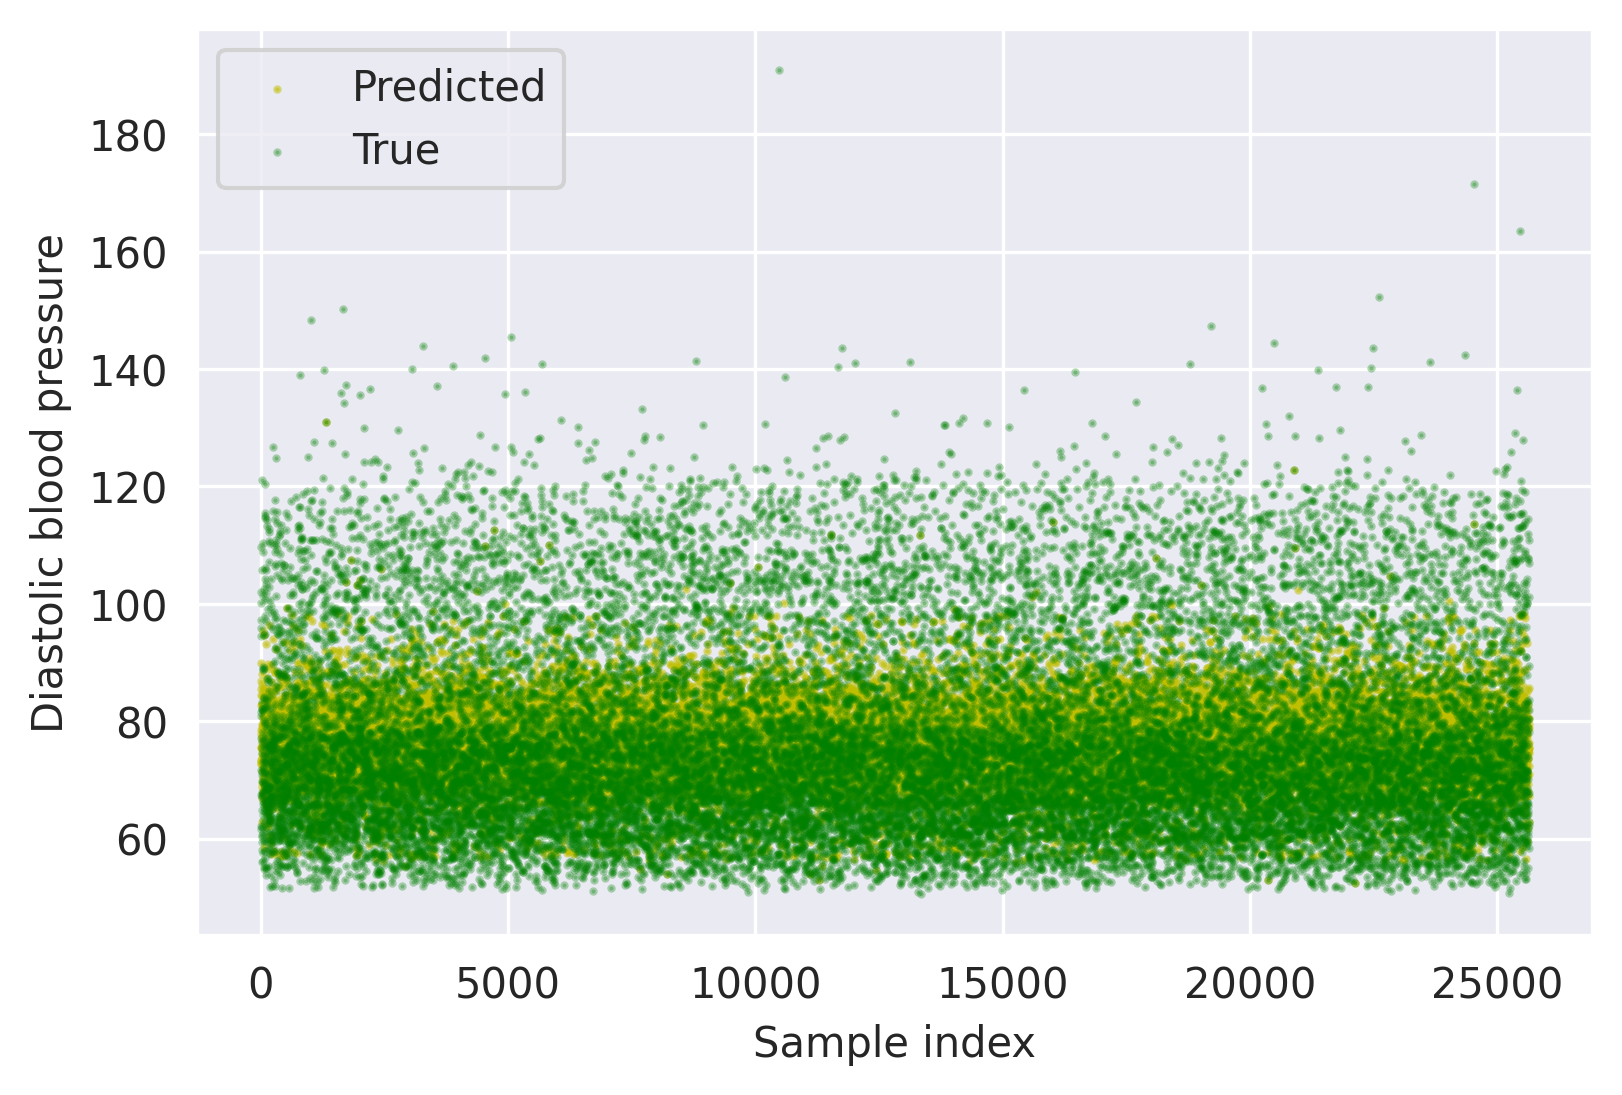

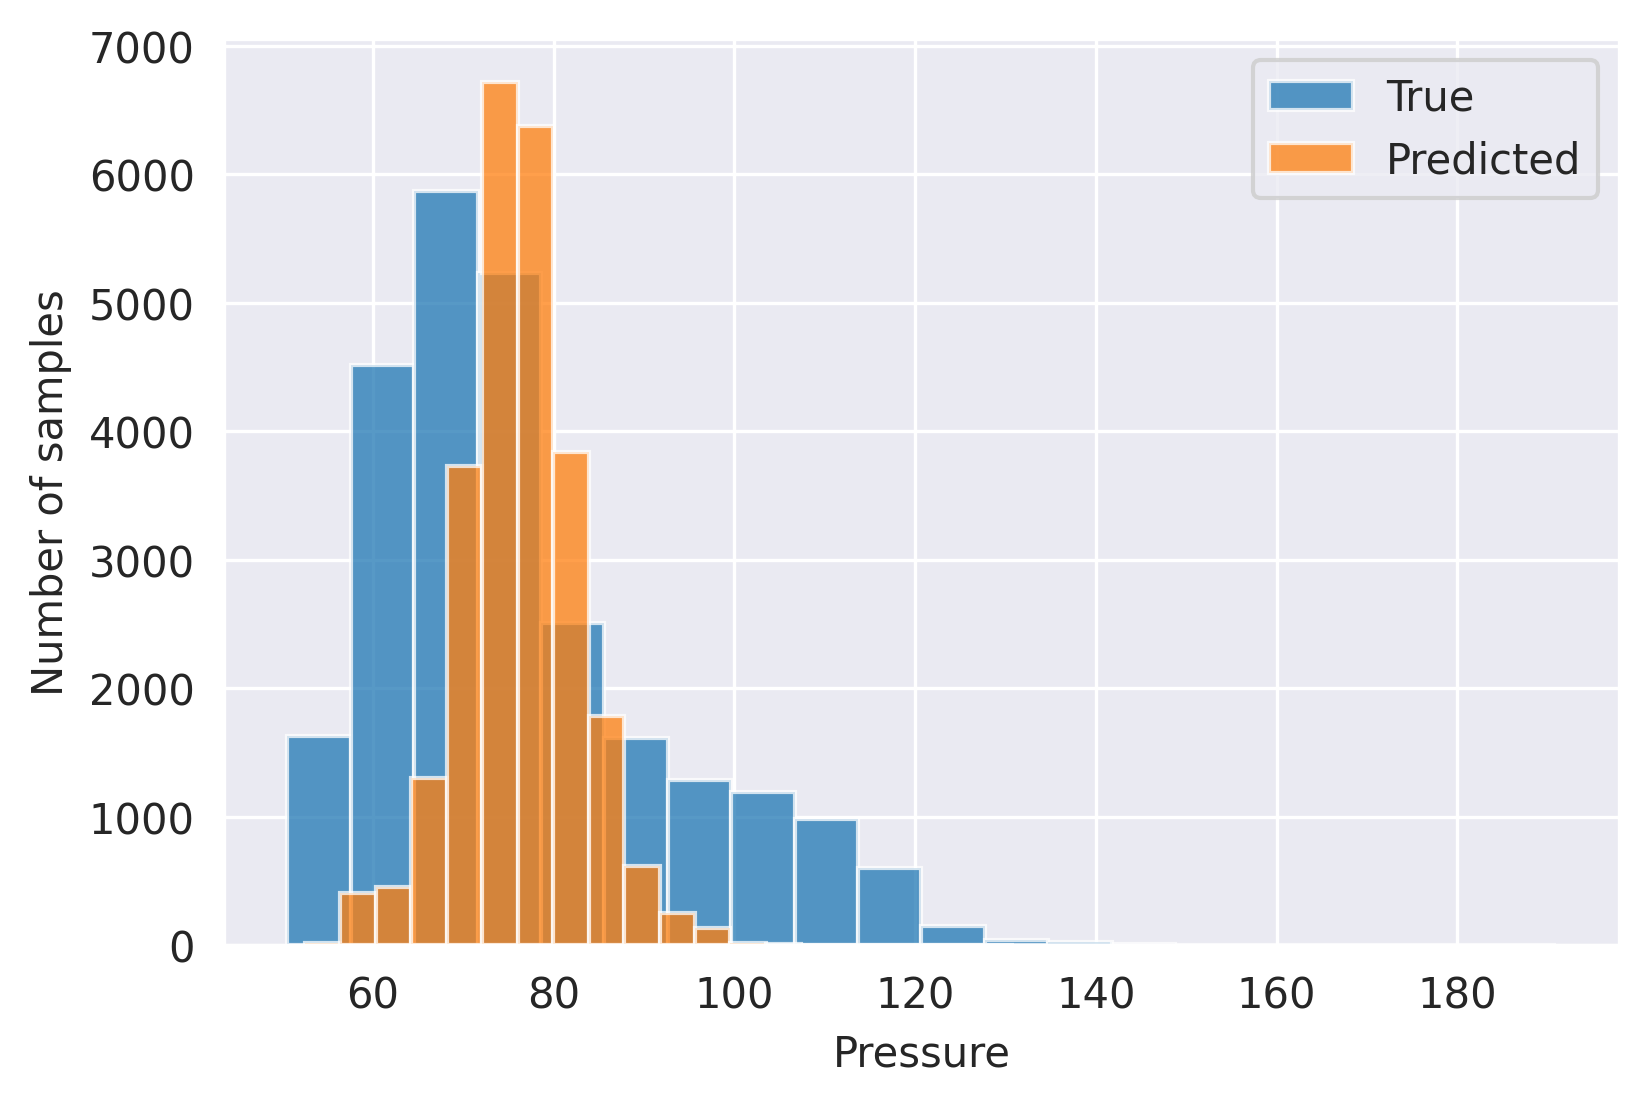

In [ ]:
print(tpot_diastolic.score(valid[selected_features], valid['BP Diastolic Pressure']))

dpi = 300
pred = tpot_diastolic.predict(valid[selected_features])
print('MAE ', mean_absolute_error(y_true=valid['BP Diastolic Pressure'], y_pred=pred))

plt.figure(dpi=dpi)
x = range(0, len(pred))
plt.scatter(x,pred, c='y', s=1, label='Predicted', alpha=0.5)
plt.scatter(x, valid['BP Diastolic Pressure'], c='g', s=1, label='True', alpha=0.3)
plt.xlabel('Sample index')
plt.ylabel('Diastolic blood pressure')
plt.legend()

plt.figure(dpi=dpi)
plt.hist(valid['BP Diastolic Pressure'], alpha=0.75, label='True', bins=20)
plt.hist(pred, alpha=0.75, label='Predicted', bins=20)
plt.legend()
plt.xlabel('Pressure')
plt.ylabel('Number of samples')